# Exploratory Data Analysis (EDA) of NYC Metro Database

## Table of Contents:
* [1. Imports](#imports)
* [2. Exploring the dataset](#exploring-dataset)
* [3. Cleaning and Transforming Data](#cleaning-data)
    * [3.1. Removing outliers](#removing-outliers)
* [4. Vizualizations](#vizualizations)

## 1. Imports <a class="anchor" id="imports"></a>

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# GLOBAL VARIABLES
DATASET_FOLDER = 'dataset'
CSV_FILE = '2015.csv'

## 2. Exploring the dataset <a class="anchor" id="exploring-dataset"></a>

In [3]:
df = pd.read_csv(os.path.join(DATASET_FOLDER, CSV_FILE))
df.describe(include=np.object)

,time,ca,unit,scp,station,linename,division,desc
count,10055314,10055314,10055314,10055314,10055314,10055314,10055314,10055314
unique,611470,731,467,219,567,112,6,2
top,2015-09-15 16:00:00,PTH08,R549,00-00-00,34 ST-PENN STA,1,IRT,REGULAR
freq,2398,55280,130452,1008292,223818,1166199,3679948,10016146


In [4]:
df.sample(10)

,time,ca,unit,scp,station,linename,division,desc,entries,exits
1280214,2015-02-16 01:00:00,R328,R361,00-05-00,PELHAM PARKWAY,25,IRT,REGULAR,1784.0,0.0
5548859,2015-07-21 17:00:00,N083,R138,01-05-00,W 4 ST-WASH SQ,ABCDEFM,IND,REGULAR,3778.0,0.0
3667280,2015-05-14 01:00:00,R236,R045,00-06-01,42 ST-GRD CNTRL,4567S,IRT,REGULAR,4383508.0,3029342.0
1560962,2015-02-26 08:00:00,B020,R263,00-06-00,AVE H,BQ,BMT,REGULAR,22115.0,111034.0
7995655,2015-10-18 12:00:00,B031,R172,01-06-01,BRIGHTON BEACH,BQ,BMT,REGULAR,719748.0,3302523.0
9911577,2015-12-26 17:00:00,H037,R349,00-00-01,SUTTER AV,L,BMT,REGULAR,474871.0,141378.0
4521694,2015-06-14 08:00:00,N043,R186,00-00-01,86 ST,BC,IND,REGULAR,5098695.0,3258780.0
8392384,2015-11-01 17:00:00,R160A,R164,00-00-01,66 ST-LINCOLN,1,IRT,REGULAR,34010976.0,17015524.0
6219524,2015-08-15 04:00:00,A016,R081,03-00-02,49 ST-7 AVE,NQR,BMT,REGULAR,11940495.0,3778199.0
250950,2015-01-09 22:52:26,N504,R021,02-06-01,42 ST-BRYANT PK,BDFM7,IND,REGULAR,4329224.0,5669452.0


In [5]:
print("Total combinations of")
print(" - ca+unit+scp      :", (df['ca'] + df['unit'] + df['scp']).unique().size)
print(" - station+linename :", (df['station'] + df['linename']).unique().size)

Total combinations of
 - ca+unit+scp      : 4627
 - station+linename : 700


## 3. Cleaning and Transforming Data <a class="anchor" id="cleaning-data"></a>

In [6]:
# Check how many null value is on the dataset
df_null_sum = df.isna().sum()
df_null_sum

time        0
ca          0
unit        0
scp         0
station     0
linename    0
division    0
desc        0
entries     0
exits       0
dtype: int64

In [7]:
# Drop rows with null values
df = df.dropna()

# Drop non regular rows
df = df[df.desc == "REGULAR"]

# Combine the columns 'ca', 'unit' and 'scp' into a new one called 'turnstile'
df['turnstile'] = df['ca'] + '-' + df['unit'] + '-' + df['scp']

# Create a separate columns for date and time
df['datetime'] = pd.to_datetime(df.time)

# Drop duplicates
df.drop_duplicates(subset=['station', 'linename', 'turnstile', 'datetime'], keep='first', inplace=True)

# Drop Columns
df.drop(['ca', 'unit', 'scp', 'division', 'time', 'desc'], axis=1, inplace=True)

# Ensure rows are sorted by time
df = df.sort_values(['station', 'turnstile', 'datetime']).reset_index()

In [8]:
# The Turnstile entries/exits seems to be a cumulative sum of the occurrences.
# So, we need to calculate the diff value between turnstile reads.
df_turnstile_group = df.groupby('turnstile')

df['diff_entries'] = df_turnstile_group['entries'].diff().fillna(0)
df['diff_exits'] = df_turnstile_group['exits'].diff().fillna(0)

df.head()

,index,station,linename,entries,exits,turnstile,datetime,diff_entries,diff_exits
0,9900134,1 AV,L,10536080.0,11482385.0,H007-R248-00-00-00,2015-12-26 08:00:00,0.0,0.0
1,9904668,1 AV,L,10536102.0,11482504.0,H007-R248-00-00-00,2015-12-26 12:00:00,22.0,119.0
2,9909222,1 AV,L,10536377.0,11482929.0,H007-R248-00-00-00,2015-12-26 16:00:00,275.0,425.0
3,9913776,1 AV,L,10536886.0,11483458.0,H007-R248-00-00-00,2015-12-26 20:00:00,509.0,529.0
4,9918322,1 AV,L,10537404.0,11484131.0,H007-R248-00-00-00,2015-12-27 00:00:00,518.0,673.0


#### Check diff_entries and diff_exits

As we can see below this columns have a lot of outliers, including negative values and huge values which doesn't make any sense.

       diff_entries    diff_exits
count  1.001615e+07  1.001615e+07
mean   4.156858e+03  3.241724e+03
std    3.784678e+06  3.229032e+06
min   -2.022943e+09 -2.080392e+09
25%    1.100000e+01  9.000000e+00
50%    7.900000e+01  5.400000e+01
75%    2.510000e+02  1.690000e+02
max    2.025053e+09  2.088518e+09


<AxesSubplot:>

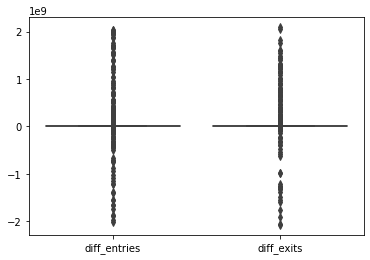

In [9]:
print(df[['diff_entries', 'diff_exits']].describe())

sns.boxplot(data=df.loc[:, ['diff_entries', 'diff_exits']])

### 4.1. Removing outliers <a class="anchor" id="removing-outliers"></a>

After removing some outliers our boxplot looks better now.

<AxesSubplot:>

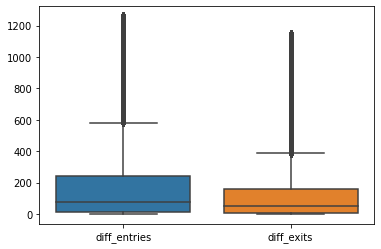

In [10]:
for key in ["diff_entries", "diff_exits"]:
    median_value = df[key].median()
    df[key][df[key] < 0] = median_value
    df[key][df[key] > df[key].quantile(0.99)] = median_value
    
sns.boxplot(data=df.loc[:, ['diff_entries', 'diff_exits']])

## 4. Vizualizations <a class="anchor" id="vizualizations"></a>

After cleaning our the data, we can take a look at more generic views considering all the turnstiles.

In [11]:
# Sum entries and exits
df['traffic'] = df['diff_entries'] + df['diff_exits']

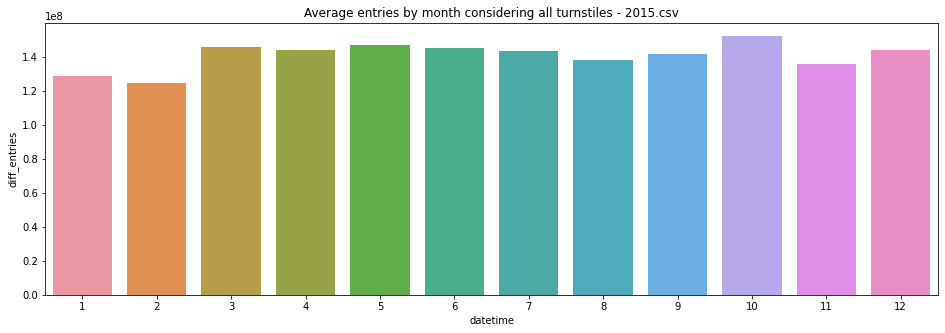

In [12]:
key = 'entries'
df_total_by_month = df.groupby(df.datetime.dt.month)[['diff_' + key]].sum().reset_index()

plt.figure(figsize=(16, 5))
ax = sns.barplot(
    data=df_total_by_month,
    x='datetime',
    y='diff_' + key,
)
_ = ax.set(title=f"Average {key} by month considering all turnstiles - {CSV_FILE}")
del df_total_by_month

[Text(0.5, 1.0, 'Number of entries and exits by day - 2015.csv')]

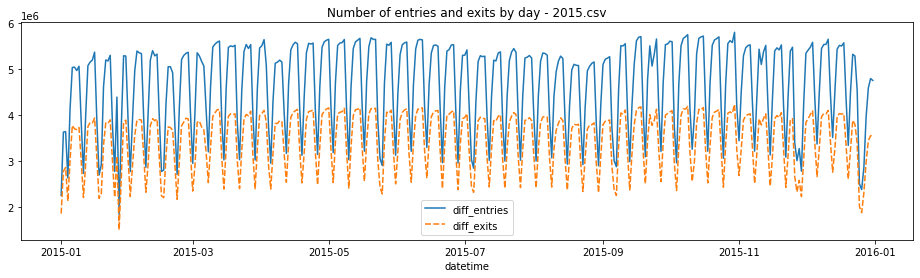

In [13]:
# Plot entries and exits over time
resample_day = df.resample('D', on='datetime')
total_traffic_by_day = resample_day[['diff_entries', 'diff_exits']].sum()

plt.figure(figsize=(16, 4))
sns.lineplot(data=total_traffic_by_day).set(title=f"Number of entries and exits by day - {CSV_FILE}")

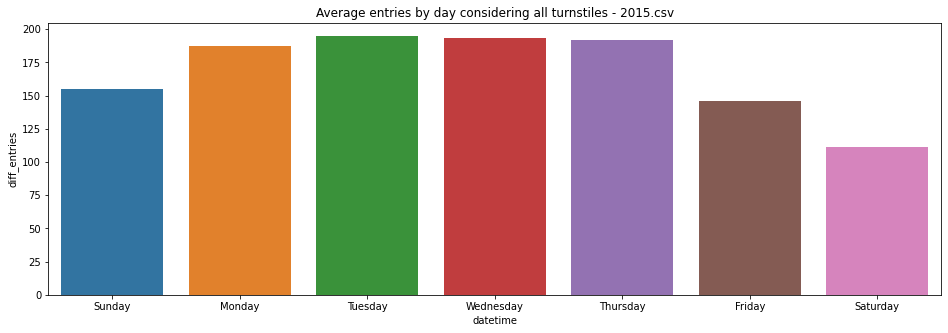

In [14]:
# Plot average entries by day
df_total_by_day = df.groupby(df.datetime.dt.day_of_week)[['diff_entries']].mean().reset_index()

plt.figure(figsize=(16, 5))
ax = sns.barplot(
    data=df_total_by_day,
    x='datetime',
    y='diff_entries',
)
_ = ax.set(title=f"Average entries by day considering all turnstiles - {CSV_FILE}")
_ = ax.set_xticks(range(7), ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])
del df_total_by_day

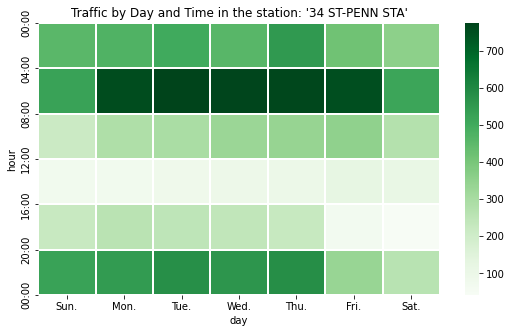

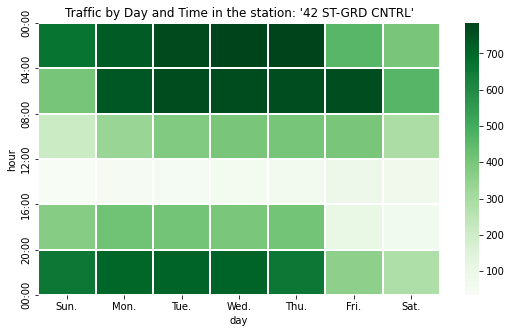

In [15]:
def plot_traffic_by_hour_and_weekday(key, cmap='Greens', n_highest=2):
    
    df_highest_traffic = df.groupby(key)['traffic'].sum().sort_values(ascending=False)

    for elem in df_highest_traffic[:n_highest].keys():
        plt.figure(figsize=(9, 5))
        df_line = df[df[key]==elem]

        # group traffic by day and intervals of 4 hours
        df_traffic = df_line.groupby(
            [df_line.datetime.dt.day_of_week, df_line.datetime.dt.round('4h').dt.hour]
        )['traffic'].mean()

        # rename axis and rotate output
        df_traffic = df_traffic.rename_axis(index=['day','hour']).unstack(level=0).apply(np.roll, shift=1)

        # rename columns
        df_traffic = df_traffic.rename(
            columns={0:'Sun.', 1:'Mon.', 2: 'Tue.', 3: 'Wed.', 4: 'Thu.', 5: 'Fri.', 6: 'Sat.'}
        )

        # plot
        sns.heatmap(
            df_traffic, cmap=cmap, linewidths=2
        ).set(title="Traffic by Day and Time in the {}: \'{}\'".format(key, elem))
        plt.yticks(range(7),["00:00","04:00","08:00","12:00","16:00","20:00","00:00"])
        plt.show()
        
plot_traffic_by_hour_and_weekday('station', 'Greens')

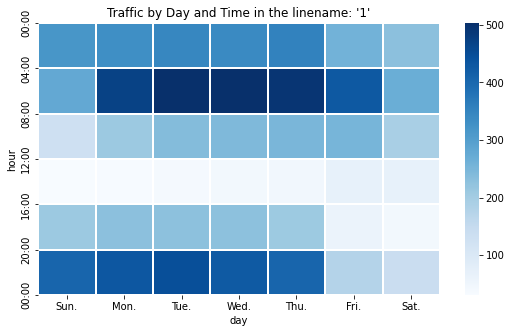

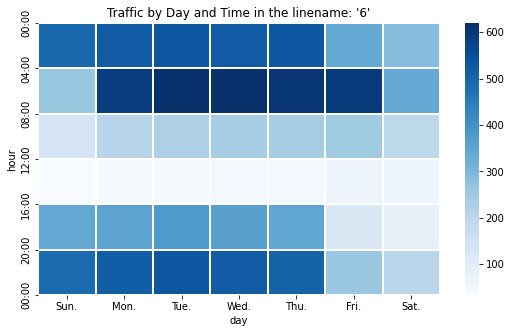

In [16]:
plot_traffic_by_hour_and_weekday('linename', 'Blues')